<a href="https://colab.research.google.com/github/lijerrymagic/MLColabAssignment/blob/master/Copy_of_9_hw_rock_paper_scissors_high_ram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework: Train a convolutional neural network to recognize rock, paper, scissors

In a  demo notebook this week, we trained a convolutional neural network to recognize handwritten digits. However, the handwritten digits dataset is a relatively easy classification problem. In this homework assignment, we will tackle a slightly more challenging problem.


"Rock paper scissors" is a game usually played between two people, in which each player simultaneously forms one of three shapes with their hand. The shapes are "rock" (a closed fist), "paper" (a flat hand), and "scissors" (a fist with the index finger and middle finger extended, forming a V). 

A player who decides to play rock will beat another player who has chosen scissors ("rock crushes scissors"), but will lose to one who has played paper ("paper covers rock"); a play of paper will lose to a play of scissors ("scissors cuts paper"). 

(Definition via [Wikipedia](https://en.wikipedia.org/wiki/Rock_paper_scissors).)

In this notebook, we will train a convolutional neural network to recognize the "rock paper scissors" hand shapes. 

Most of the code is provided for you, but you will have to make some small changes, as directed.

### Import libraries

First, we will set up our Colab environment. Make sure that you are using a GPU runtime, to speed up training: use Runtime > Change runtime type and set Hardware acceleration to GPU.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
print(tf.__version__) 

2.3.0


## Import data

The "rock paper scissors" dataset is available directly from the Tensorflow package. In the cells that follow, we'll get the data, plot a few examples, and also do some preprocessing.

In [5]:
import tensorflow_datasets as tfds

In [6]:
(ds_train, ds_test), ds_info = tfds.load(
    'rock_paper_scissors',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True
)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteNLAPZ3/rock_paper_scissors-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteNLAPZ3/rock_paper_scissors-test.tfrecord


Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


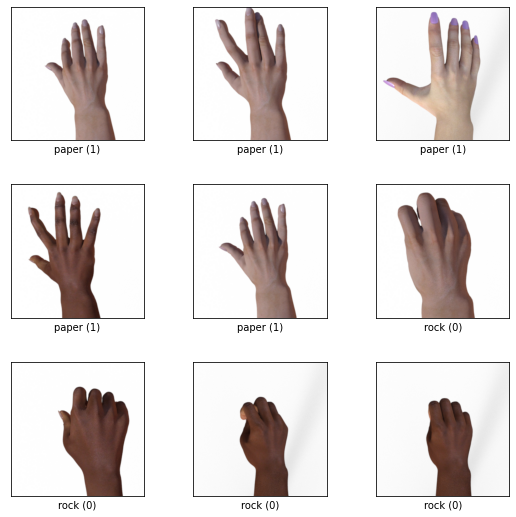

In [7]:
fig = tfds.show_examples(ds_info, ds_train)

In [8]:
classes = np.array(['rock', 'paper', 'scissors'])

In [9]:
# Convert to numpy, since we are more comfortable
# working with numpy arrays. Also rescale images

train_numpy = np.vstack(tfds.as_numpy(ds_train))
test_numpy = np.vstack(tfds.as_numpy(ds_test))

X_train = np.array(list(map(lambda x: x[0]['image'], train_numpy)))
y_train = np.array(list(map(lambda x: x[0]['label'], train_numpy)))

X_test = np.array(list(map(lambda x: x[0]['image'], test_numpy)))
y_test = np.array(list(map(lambda x: x[0]['label'], test_numpy)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """


In [10]:
X_train = X_train/255.0
X_test = X_test/255.0

In [7]:
X_train.shape

(2520, 300, 300, 3)

In [28]:
y_train.shape

(2520,)

In [10]:
X_test.shape

(372, 300, 300, 3)

In [11]:
y_test.shape

(372,)

In [12]:
# how many of each class?
c = np.bincount(y_train)
for idx, cls in enumerate(classes):
  print ("%s: %d training samples" % (cls, c[idx])) 

rock: 840 training samples
paper: 840 training samples
scissors: 840 training samples


## Train a convolutional neural network


Next,  you will train a convolutional neural network on this data. For your convenience, I have copied over a basic network based on this week's demo, with a sequence of `Conv2D`, `BatchNormalization`, `Activation`, `MaxPooling2D`, `Dropout`, and `Dense` layers, as a starting point. 

However, you will have to make some changes:

* Change the input shape to match the "volume" of the images in this dataset. (This should reflect both the resolution - height and width - and the number of color "channels".)
* Change the output shape to match the number of classes in this dataset.

In [11]:
K.clear_session() # free up some memory if you can

In [12]:
model_conv = Sequential()                           # Linear stacking of layers

# Convolution Layer 1
model_conv.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3))) # 32 3x3 kernels
model_conv.add(BatchNormalization(axis=-1))               # normalize 
convLayer01 = Activation('relu')                          # activation
model_conv.add(convLayer01)

# Convolution Layer 2
model_conv.add(Conv2D(32, (3, 3)))                        # 32 3x3 kernels 
model_conv.add(BatchNormalization(axis=-1))               # normalize 
model_conv.add(Activation('relu'))                        # activation
convLayer02 = MaxPooling2D(pool_size=(2,2))               # Pool the max values over a 2x2 kernel
model_conv.add(convLayer02)

# Convolution Layer 3
model_conv.add(Conv2D(64,(3, 3)))                         # 64 3x3 kernels
model_conv.add(BatchNormalization(axis=-1))               # normalize
convLayer03 = Activation('relu')                          # activation
model_conv.add(convLayer03)

# Convolution Layer 4
model_conv.add(Conv2D(64, (3, 3)))                        # 64 3x3 kernels
model_conv.add(BatchNormalization(axis=-1))               # normalize
model_conv.add(Activation('relu'))                        # activation
convLayer04 = MaxPooling2D(pool_size=(2,2))               # Pool the max values over a 2x2 kernel
model_conv.add(convLayer04)
model_conv.add(Flatten())                                 # Flatten final 4x4x64 output matrix into a 1024-length vector

# Fully Connected Layer 5
model_conv.add(Dense(128))                                # 128 fully connected nodes
model_conv.add(BatchNormalization())                      # normalization
model_conv.add(Activation('relu'))                        # activation

# Fully Connected Layer 6                       
model_conv.add(Dropout(0.2))                              # 20% dropout of randomly selected nodes
model_conv.add(Dense(3))                                 # final fully connected nodes
model_conv.add(Activation('softmax'))                     # softmax activation


In [13]:
model_conv.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 298, 298, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 298, 298, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 296, 296, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 296, 296, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 296, 296, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 32)      0

In [14]:
opt = optimizers.Adam(lr=0.00005)

model_conv.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
hist = model_conv.fit(X_train, y_train, 
                           epochs = 10, batch_size=32,
                           validation_data=(X_test, y_test))

Epoch 1/10
79/79 [==============================] - 11s 143ms/step - loss: 0.1265 - accuracy: 0.9655 - val_loss: 2.4530 - val_accuracy: 0.3333
Epoch 2/10
79/79 [==============================] - 10s 131ms/step - loss: 0.0134 - accuracy: 1.0000 - val_loss: 3.0558 - val_accuracy: 0.3333
Epoch 3/10
79/79 [==============================] - 10s 131ms/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 3.2232 - val_accuracy: 0.3333
Epoch 4/10
79/79 [==============================] - 10s 131ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 2.5907 - val_accuracy: 0.4059
Epoch 5/10
79/79 [==============================] - 10s 131ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 2.3703 - val_accuracy: 0.5296
Epoch 6/10
79/79 [==============================] - 10s 131ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 2.3165 - val_accuracy: 0.5376
Epoch 7/10
79/79 [==============================] - 10s 131ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 2.0656 - val_accuracy: 0.5376

Did you see a problem at this point? When you try to fit your model, you may find that you need or want to make further changes:

* Does your Colab session crash, or do you get an OOM (out of memory) error message (e.g. `ResourceExhaustedError: OOM`)? Each image in this dataset is somewhat larger than the MNIST samples, so you may not be able to fit as much in memory at once. You can reduce your batch size, so that the stochastic gradient descent is trained over a smaller number of images at a time. (TF includes a lot of utilities for working with big data more effectively - notably, we can read batches of data from disk instead of keeping all the data in memory - but this is one simple fix!) If you have to, you can also change the model architecture to use less memory. 
* Does your accuracy continue to increase until the model training stops? You may want more epochs.
* Does your test accuracy fail to converge to something above 1/3? You may have to reduce the learning rate.  Does your test accuracy change very little on each epoch? You may have to increase the learning rate. (You can also try another optimizer to see if it converges better, e.g. `RMSprop` instead of `Adam`.)
* Is your model overfitting? There are some methods we used in our demo to mitigate this. You can use a validation set for early stopping, but be careful:  with SGD and a small batch size, the error curves bounce around a lot, so early stopping may not give good results. You can also try using data augmentation, as in the demo notebook.
* If you are feeling adventurous, you can also experiment with different network architectures. We shared some notes on that topic, [here](https://cs231n.github.io/convolutional-networks/). 

The only *requirement* in this section is that your model should achieve a test accuracy above 40% for at least 5 epochs in a row. This is achievable without early stopping, data augmentation, or changes to the network architecture.

Plot your training accuracy and validation accuracy and then print the model performance on the test set.

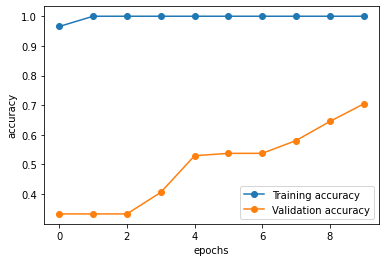

In [16]:
tr_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

plt.plot(tr_accuracy, marker='o');
plt.plot(val_accuracy, marker='o');
plt.xlabel('epochs');
plt.ylabel('accuracy');
plt.legend(['Training accuracy', 'Validation accuracy']);


In [17]:
score = model_conv.evaluate(X_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

12/12 [==============================] - 0s 38ms/step - loss: 0.9139 - accuracy: 0.7043
Test score: 0.9139271378517151
Test accuracy: 0.7043010592460632


## Try your own test samples

Take a series of photographs of your own hand making the rock, paper, scissors gestures, against a white background. (Three photographs: one for each gesture.) Use the photo editing tool of your choice to crop each image to a roughly square area. 

Upload one image in the following cell. Then, use your fitted model to classify it - is it rock, paper, or scissors?

In [18]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

KeyboardInterrupt: ignored

In [19]:
from PIL import Image
 
# Edit the filename here as needed
filename1 = 'rock.jpeg'
 
# pre-process image
image1 = Image.open(filename1)
image1_resized = image1.resize((300, 300), Image.BICUBIC)
test_sample_1 = np.array(image1_resized)/255.0
test_sample_1 = test_sample_1.reshape(1, 300, 300, 3)

In [21]:
test_probs_1 = model_conv.predict(test_sample_1)

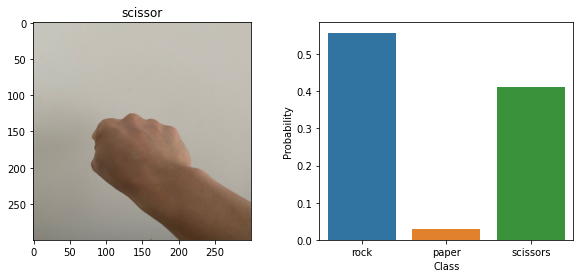

In [22]:
plt.figure(figsize=(10,4));

plt.subplot(1,2,1)
plt.title("scissor")
plt.imshow(test_sample_1.reshape(300, 300, 3));

plt.subplot(1,2,2)
sns.barplot(classes, test_probs_1.squeeze());
plt.ylabel("Probability");
plt.xlabel("Class");

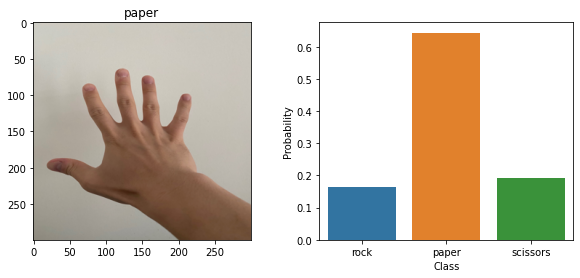

In [24]:
# Edit the filename here as needed
filename2 = 'paper.jpeg'
 
# pre-process image
image2 = Image.open(filename2)
image_resized_2 = image2.resize((300, 300), Image.BICUBIC)
test_sample_2 = np.array(image_resized_2)/255.0
test_sample_2 = test_sample_2.reshape(1, 300, 300, 3)
test_probs_2 = model_conv.predict(test_sample_2)
plt.figure(figsize=(10,4));

plt.subplot(1,2,1)
plt.title("paper")
plt.imshow(test_sample_2.reshape(300, 300, 3));

plt.subplot(1,2,2)
sns.barplot(classes, test_probs_2.squeeze());
plt.ylabel("Probability");
plt.xlabel("Class");

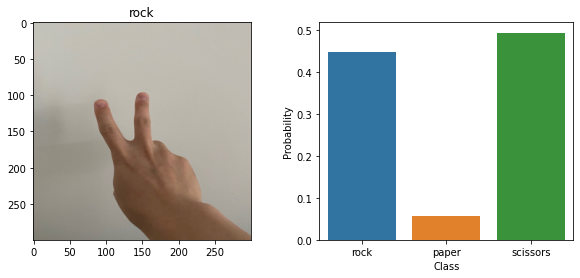

In [28]:
# Edit the filename here as needed
filename3 = 'scissor.jpeg'
 
# pre-process image
image3 = Image.open(filename3)
image_resized_3 = image3.resize((300, 300), Image.BICUBIC)
test_sample_3 = np.array(image_resized_3)/255.0
test_sample_3 = test_sample_3.reshape(1, 300, 300, 3)
test_probs_3 = model_conv.predict(test_sample_3)
plt.figure(figsize=(10,4));

plt.subplot(1,2,1)
plt.title("rock")
plt.imshow(test_sample_3.reshape(300, 300, 3));

plt.subplot(1,2,2)
sns.barplot(classes, test_probs_3.squeeze());
plt.ylabel("Probability");
plt.xlabel("Class");

Add some additional cells, so that you read in all three of your images, and show the model prediction for each of your three test samples. Indicate the true label - is it rock, paper, or scissors? - in the title of each plot. 

## What to submit

Submit your Colab notebook, including all outputs, as a PDF. 

Make sure you:

* Achieve test or validation accuracy above 1/3 for at least 5 epochs in a row.
* Show your own photographs - one each for rock, paper, and scissors - and the prediction of your model for each photograph.